# Image Analysis with Image Classification (VGG16)

*This notebook provides a clear, end‑to‑end example of the **Image Data Analysis Roadmap** using a VGG16 model. Follow the sections in order: load data, inspect & clean, preprocess & augment, perform EDA, train VGG16, and evaluate (metrics + confusion matrix), then summarize insights.*

> Tip: You can swap the dataset between **CIFAR‑10** (quick demo) and a **custom ImageFolder** (your own images) without changing the overall workflow.


## What we’ll do
1) Setup & Config → seeds, device, knobs  
2) Transforms → preprocessing & augmentation  
3) Load Data → CIFAR‑10 or ImageFolder; splits  
4) Inspect & Clean → sample grid, class distribution  
5) Aug Preview → verify transforms visually  
6) Model → VGG16 (pretrained), replace head  
7) Train & Validate → curves, best checkpoint  
8) Test & Explain → accuracy, confusion matrix, Grad‑CAM  
9) Results & Report → table template + notes  
10) Summary → next steps


### 1) Setup & Config 

We centralize all experiment knobs here so you can tweak them without touching the rest of the notebook.


In [1]:
# ==== Config ====
USE_CIFAR10 = True          # If False, use ImageFolder at CUSTOM_DATA_DIR
CUSTOM_DATA_DIR = "data"    # Expect data/train, data/val, data/test

IMG_SIZE = 224              # VGG16 expects 224x224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 5
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
RANDOM_SEED = 42
SAVE_BEST = True
MODEL_OUT = "vgg16_best.pth"


**Analysis**
- **Success criteria (define now):** e.g., *Val acc ≥ 80% by epoch 5; |train–val| ≤ 7pp*.
- **Experiment grid:** (epochs × LR) = {(3, 1e‑3), (5, 1e‑3), (5, 5e‑4)}.
- **Failure modes:** slow training → freeze backbone / reduce IMG_SIZE; unstable loss → lower LR / lighten jitter.
- **Artifacts to log:** config dict, seed, package versions, GPU type, epoch time.
  
**Exercise:** Write your success criterion below and list 2 runs you plan to try.


### 2) Imports, Device & Reproducibility

We import PyTorch/torchvision, detect GPU, and fix seeds for repeatability.


In [2]:
import os, random, time, math, itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Seeds
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

Device: cuda


**Analysis**
- With seeds fixed and val transforms deterministic, results should be similar across runs.
- If training on CPU: reduce epochs/batch size for time.
  
**Exercise:** Note the device printed; if CPU, adjust `EPOCHS` to a lower number you can afford.


### 3) Data Transforms - *preprocessing & augmentation*

Training uses light augmentation; val/test are deterministic. We match ImageNet normalization for VGG16.


In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

**Analysis & Diagnostics - Transforms**
- **Normalization check:** Using ImageNet stats prevents distribution shift to VGG16.
- **Aug strength:** If train≫val → stronger aug; if both low/noisy → dial back aug or LR.
  
**Exercise:** Add `transforms.RandomRotation(10)` to `train_tfms` and later compare validation accuracy.


### 4) Load Data - *CIFAR‑10 or ImageFolder*

Use CIFAR‑10 for baseline; switch to your foldered dataset when ready.


In [4]:
if USE_CIFAR10:
    trainset_full = datasets.CIFAR10(root="data_cifar10", train=True, download=True, transform=train_tfms)
    testset = datasets.CIFAR10(root="data_cifar10", train=False, download=True, transform=val_tfms)
    num_classes = 10
    class_names = trainset_full.classes
    # Validation split
    val_ratio = 0.1
    val_size = int(len(trainset_full) * val_ratio)
    train_size = len(trainset_full) - val_size
    trainset, valset = random_split(trainset_full, [train_size, val_size], generator=torch.Generator().manual_seed(RANDOM_SEED))
else:
    train_dir = os.path.join(CUSTOM_DATA_DIR, "train")
    val_dir   = os.path.join(CUSTOM_DATA_DIR, "val")
    test_dir  = os.path.join(CUSTOM_DATA_DIR, "test")

    trainset = datasets.ImageFolder(train_dir, transform=train_tfms)
    valset   = datasets.ImageFolder(val_dir, transform=val_tfms)
    testset  = datasets.ImageFolder(test_dir, transform=val_tfms)

    class_names = trainset.classes
    num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)
print("Train/Val/Test sizes:", len(trainset), len(valset), len(testset))

100%|██████████| 170M/170M [04:39<00:00, 611kB/s]  


Extracting data_cifar10\cifar-10-python.tar.gz to data_cifar10
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Num classes: 10
Train/Val/Test sizes: 45000 5000 10000


**Analysis - Data Integrity**
- Quickly scan class names for typos; ensure splits are sensible.
- Avoid leakage: same/similar images must not appear across different splits.
  
**Exercise:** If using ImageFolder, list any classes with very few samples and propose remedies (augmentation / more data).


### 5) DataLoaders - *batching & shuffling*

We prepare loaders with shuffling for train and deterministic order for val/test.


In [5]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
valloader   = DataLoader(valset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

**Analysis**
- If I/O is slow, increase `NUM_WORKERS`; if unstable, reduce it.
- `pin_memory=True` helps on GPU.

**Exercise:** Time one epoch later and compute images/sec. Record it in the results table.


### 6) Inspect Samples & Class Distribution - *quick EDA*

We visualize a grid of samples and check class counts.


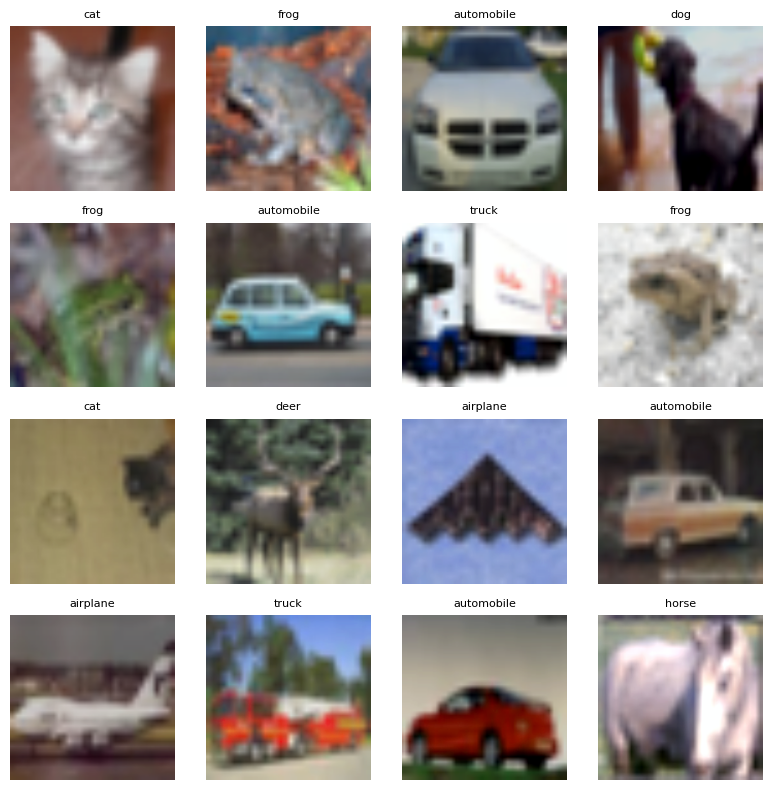

In [6]:
def imshow_grid(images, labels, classes, n=16):
    images = images[:n].cpu()
    labels = labels[:n].cpu()
    grid = int(math.sqrt(n))
    fig, axes = plt.subplots(grid, grid, figsize=(8,8))
    idx = 0
    for r in range(grid):
        for c in range(grid):
            img = images[idx].permute(1,2,0).numpy()
            img = (img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])).clip(0,1)
            axes[r,c].imshow(img); axes[r,c].axis('off')
            axes[r,c].set_title(classes[labels[idx].item()], fontsize=8)
            idx += 1
    plt.tight_layout(); plt.show()

batch_imgs, batch_labels = next(iter(trainloader))
imshow_grid(batch_imgs, batch_labels, class_names, n=16)

### 7) Augmentation Preview

We visualize augmented images to ensure transforms preserve semantics.


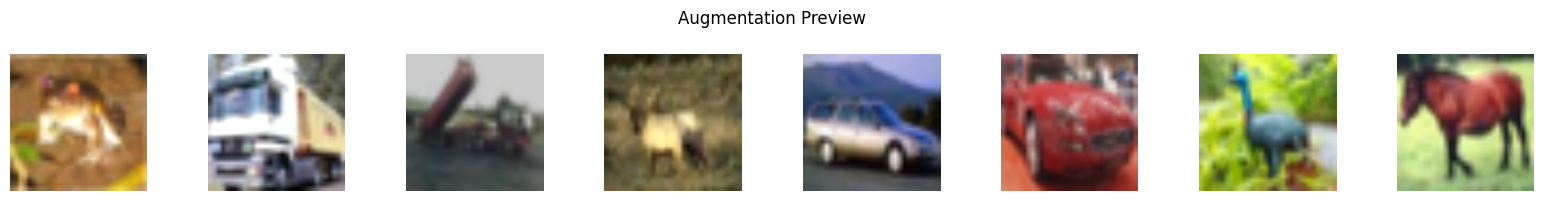

In [7]:
preview_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
])

def show_aug_examples(dataset, n=8):
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    for i in range(n):
        x, y = dataset[i]
        x_np = x.permute(1,2,0).numpy()
        x_np = (x_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
        x_np = np.clip(x_np, 0, 1)
        axes[i].imshow(x_np); axes[i].axis('off')
    plt.suptitle("Augmentation Preview"); plt.tight_layout(); plt.show()

base_trainset = trainset.dataset if hasattr(trainset, 'dataset') else trainset
show_aug_examples(base_trainset, n=8)

**Analysis**
- Human should still label them correctly.
- Balance diversity and realism.

**Exercise:** Increase jitter strength and note any harmful artifacts you observe.


### 8) Build VGG16 (Pretrained) - *transfer learning*

We replace the classifier head; start by freezing the feature extractor for a fast baseline.


In [8]:
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
in_features = vgg.classifier[-1].in_features
vgg.classifier[-1] = nn.Linear(in_features, num_classes)

for p in vgg.features.parameters():
    p.requires_grad = False  # unfreeze later for better accuracy

vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)

print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


**Analysis - Transfer Strategy**
- **Baseline:** head‑only training is your control.
- **Upgrade:** unfreeze last conv block later with a **smaller LR**.

**Exercise:** Note the in_features printed and confirm the head output matches `num_classes`.


### 9) Training & Evaluation Utilities

We implement clean functions for one epoch of training and evaluation.


In [9]:
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    return correct / targets.size(0)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        running_acc  += accuracy_from_logits(logits, y) * x.size(0)
    n = len(loader.dataset)
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, running_acc = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        running_acc  += accuracy_from_logits(logits, y) * x.size(0)
    n = len(loader.dataset)
    return running_loss / n, running_acc / n

**Analysis - Metrics**
- Accuracy is fine for balanced classes; for imbalance, add macro‑F1.
  
**Exercise:** Extend `evaluate` to also compute macro‑F1 using `sklearn.metrics.f1_score` and compare to accuracy.


### 10) Train the Model

We run multiple epochs, adjust LR when val stalls, save best, and plot curves.


Epoch 01 | Train loss 0.9030 acc 0.7330 | Val loss 0.5352 acc 0.8238 | 251.3s
  ↳ Saved new best to vgg16_best.pth
Epoch 02 | Train loss 0.7629 acc 0.7791 | Val loss 0.5124 acc 0.8386 | 249.1s
  ↳ Saved new best to vgg16_best.pth
Epoch 03 | Train loss 0.6953 acc 0.7964 | Val loss 0.4778 acc 0.8468 | 248.6s
  ↳ Saved new best to vgg16_best.pth
Epoch 04 | Train loss 0.6637 acc 0.8069 | Val loss 0.4703 acc 0.8480 | 248.3s
  ↳ Saved new best to vgg16_best.pth
Epoch 05 | Train loss 0.6268 acc 0.8190 | Val loss 0.4752 acc 0.8544 | 254.0s
  ↳ Saved new best to vgg16_best.pth


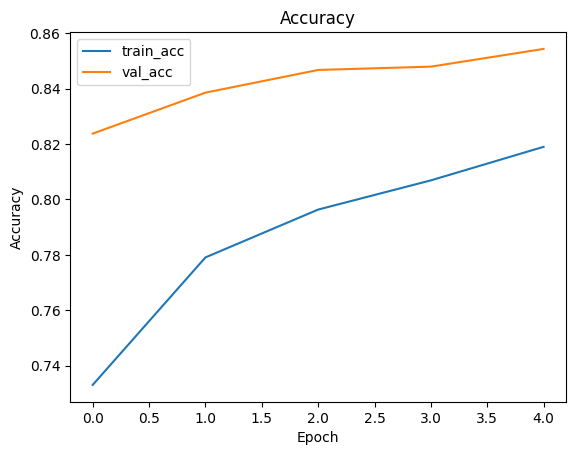

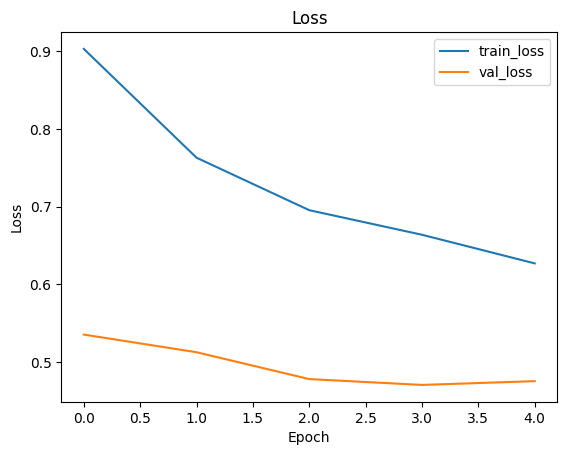

In [10]:
best_val_acc = -1.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS+1):
    start = time.time()
    tl, ta = train_one_epoch(vgg, trainloader, optimizer, criterion)
    vl, va = evaluate(vgg, valloader, criterion)
    scheduler.step(va)
    history["train_loss"].append(tl); history["train_acc"].append(ta)
    history["val_loss"].append(vl);   history["val_acc"].append(va)
    elapsed = time.time() - start
    print(f"Epoch {epoch:02d} | Train loss {tl:.4f} acc {ta:.4f} | Val loss {vl:.4f} acc {va:.4f} | {elapsed:.1f}s")
    if SAVE_BEST and va > best_val_acc:
        best_val_acc = va
        torch.save(vgg.state_dict(), MODEL_OUT)
        print(f"  ↳ Saved new best to {MODEL_OUT}")

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy"); plt.show()

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss"); plt.show()

**Analysis**
- **Overfitting:** train↑ val↓ → add augmentation/regularization or unfreeze gradually with lower LR.
- **Underfitting:** both low → train longer, lower LR, or unfreeze more layers.
  
**Exercise:** Note epoch of best val accuracy and the learning‑curve shape in your results table.


### 11) Test Evaluation & Confusion Matrix - *generalization check*

We compute test accuracy, confusion matrix, and per‑class report.


Test Accuracy: 0.8583


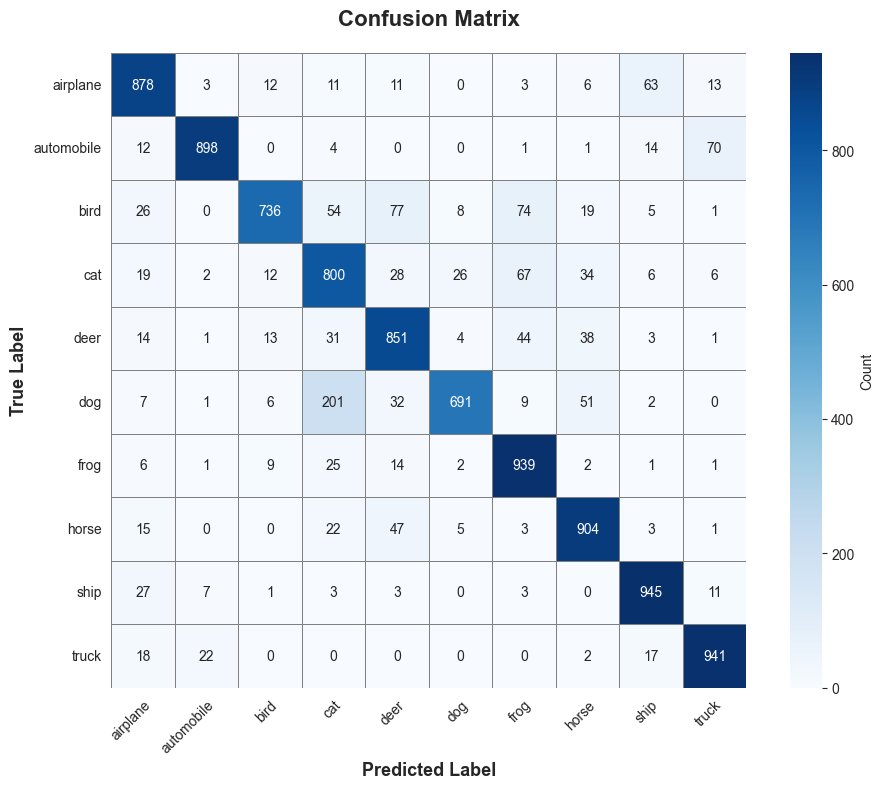


Classification Report:

              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.96      0.90      0.93      1000
        bird       0.93      0.74      0.82      1000
         cat       0.70      0.80      0.74      1000
        deer       0.80      0.85      0.83      1000
         dog       0.94      0.69      0.80      1000
        frog       0.82      0.94      0.88      1000
       horse       0.86      0.90      0.88      1000
        ship       0.89      0.94      0.92      1000
       truck       0.90      0.94      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



In [19]:
@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    all_preds, all_targets = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        all_preds.extend(preds)
        all_targets.extend(y.numpy().tolist())
    return np.array(all_preds), np.array(all_targets)

preds, targets = predict_all(vgg, testloader)
test_acc = (preds == targets).mean()
print(f"Test Accuracy: {test_acc:.4f}")

# Compute confusion matrix
cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))

# Create a more beautiful visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Use seaborn for better aesthetics
import seaborn as sns
sns.set_style("whitegrid")

# Create heatmap with annotations
im = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names,
                 cbar_kws={'label': 'Count'},
                 linewidths=0.5, linecolor='gray',
                 square=True, ax=ax)

# Customize the plot
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')

# Rotate labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=0)


plt.tight_layout()
plt.show()


print("\nClassification Report:\n")
print(classification_report(targets, preds, target_names=class_names))

**Analysis**
- Identify bottom‑3 classes by recall; inspect 10 misclassifications each to find patterns.
- Consider class‑balanced sampling or targeted augmentation.

**Exercise:** Write two concrete actions to improve the weakest classes.


### 12) Grad‑CAM *qualitative explainability*

We overlay Grad‑CAM to visualize which regions influenced predictions.


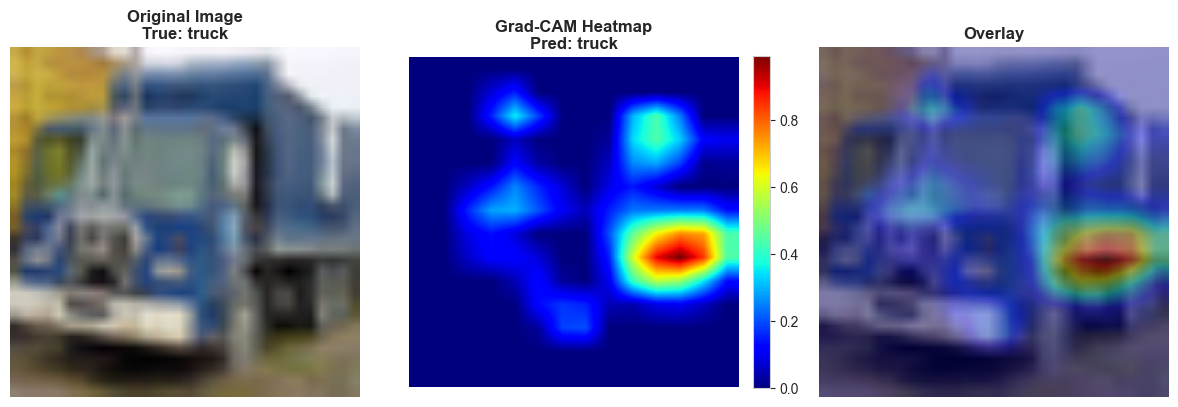

Randomly selected image 15 from batch


In [30]:
# FIX: Disable in-place operations in VGG
def disable_inplace_relu(model):
    for module in model.modules():
        if isinstance(module, torch.nn.ReLU):
            module.inplace = False

# Apply the fix to your VGG model
disable_inplace_relu(vgg)

# Now the Grad-CAM code will work
import torch.nn.functional as F
import random

# Last conv layer in VGG16
target_layer = vgg.features[28]
_acts = None
_grads = None

def _forward_hook(module, inp, out):
    global _acts
    _acts = out

def _backward_hook(module, grad_in, grad_out):
    global _grads
    _grads = grad_out[0]

fh = target_layer.register_forward_hook(_forward_hook)
bh = target_layer.register_full_backward_hook(_backward_hook)

@torch.no_grad()
def _denorm(img_t):
    img = img_t.clone().cpu().permute(1, 2, 0).numpy()
    img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    return np.clip(img, 0, 1)

def grad_cam(model, x, class_idx=None):
    global _acts, _grads
    _acts, _grads = None, None
    
    model.eval()
    x = x.to(device).requires_grad_(True)
    
    logits = model(x)
    
    if class_idx is None:
        class_idx = logits.argmax(1).item()
    
    score = logits[0, class_idx]
    model.zero_grad()
    score.backward()
    
    acts = _acts[0]
    grads = _grads[0]
    
    weights = grads.mean(dim=(1, 2))
    cam = (weights[:, None, None] * acts).sum(dim=0)
    
    cam = torch.clamp(cam, min=0)
    cam -= cam.min()
    if cam.max() > 0:
        cam /= cam.max()
    
    cam = F.interpolate(
        cam[None, None], 
        size=(x.shape[2], x.shape[3]), 
        mode="bilinear", 
        align_corners=False
    )[0, 0]
    
    return cam.detach().cpu().numpy(), class_idx

# RANDOMLY select an image
images, labels = next(iter(testloader))
random_idx = random.randint(0, len(images) - 1)  # Random index

img = images[random_idx].unsqueeze(0)
true_label = labels[random_idx].item()

heatmap, pred_idx = grad_cam(vgg, img)
base = _denorm(images[random_idx])

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title(f"Original Image\nTrue: {class_names[true_label]}", fontsize=12, fontweight='bold')
plt.imshow(base)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Grad-CAM Heatmap\nPred: {class_names[pred_idx]}", fontsize=12, fontweight='bold')
plt.imshow(heatmap, cmap='jet')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay", fontsize=12, fontweight='bold')
plt.imshow(base)
plt.imshow(heatmap, alpha=0.4, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()

fh.remove()
bh.remove()

print(f"Randomly selected image {random_idx + 1} from batch")

**Analysis**
- Attention should land on the object of interest; if not, revisit preprocessing/augmentation.
- Compare Grad‑CAM on correct vs incorrect predictions.

**Exercise:** Run Grad‑CAM on a misclassified example and describe what the heatmap suggests.


## ✅ Summary & Next Steps

**You completed:** config → transforms → data loading → EDA → augmentation preview → VGG16 setup → training → evaluation → Grad‑CAM 